<a href="https://colab.research.google.com/github/KTada777/Bayesian_SolarCell_1D-Citrcuit/blob/main/230726R1_pymc5%2BNumpyro_PVparameter_demo_IntJSolEner_10k_10k.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!cat /proc/cpuinfo | awk '/processor/,/cpu MHz/'

processor	: 0
vendor_id	: GenuineIntel
cpu family	: 6
model		: 79
model name	: Intel(R) Xeon(R) CPU @ 2.20GHz
stepping	: 0
microcode	: 0xffffffff
cpu MHz		: 2200.154
processor	: 1
vendor_id	: GenuineIntel
cpu family	: 6
model		: 79
model name	: Intel(R) Xeon(R) CPU @ 2.20GHz
stepping	: 0
microcode	: 0xffffffff
cpu MHz		: 2200.154


In [ ]:
import sys
print(sys.version)

3.10.6 (main, May 29 2023, 11:10:38) [GCC 11.3.0]


In [ ]:
!pip install numpyro

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 304.6/304.6 kB 3.7 MB/s eta 0:00:00


In [ ]:
import matplotlib as mpl
import matplotlib.pyplot as plt
#
import numpy as np
#
import pymc as pm
import arviz as az
import time
#
import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)
#
import pymc.sampling_jax
import numpyro
#
print(pm.__version__)

5.1.2


In [ ]:
def pm_I_Roberts_g(Iph, Rp, Rs, I0, n, V):
    Iph = Iph / 1000  #mA
    Rs = Rs / 1e3     #mOhm
    I0 = I0 / 1e9     #nA
    nVt = n*0.026    #Vt(RT)=26 mV
    x = np.log(I0 * (Rs * Rp) / (Rs + Rp) / nVt) + (Rp / (Rs + Rp)) * (V + Rs * (I0 + Iph)) / nVt

    return (V - nVt * (pm_Roberts_g(x) - np.log(I0 * Rs * Rp / (Rs + Rp) / nVt))) / Rs

In [ ]:
def pm_Roberts_g(x):
    e_1 = np.exp(-1)
    e1 = np.exp(1)
    g = pm.math.switch((x <= -(e_1)), x, pm.math.switch((x >= e1), np.log(x), -e1 + (1 + e1) / (2 * e1) * (x + e1)))
#
    eg = np.exp(g)
    g = g - (2 * (g + eg - x) * (1 + eg)) / (2 * (1 + eg) ** 2 - (g + eg - x) * eg)
#
    eg = np.exp(g)
    g = g - (2 * (g + eg - x) * (1 + eg)) / (2 * (1 + eg) ** 2 - (g + eg - x) * eg)
#
    eg = np.exp(g)
    g = g - (2 * (g + eg - x) * (1 + eg)) / (2 * (1 + eg) ** 2 - (g + eg - x) * eg)
#
    eg = np.exp(g)
    g = g - (2 * (g + eg - x) * (1 + eg)) / (2 * (1 + eg) ** 2 - (g + eg - x) * eg)
#
    return g

In [ ]:
#
# I-V of Si solar cell from T. Easwarakhanthan et al., Int. J. Sol. Energy vol. 4 (1986) 1.
#
X = np.array([-0.2057, -0.1291, -0.0588,  0.0057,  0.0646,  0.1185,  0.1678,  0.2132,  0.2545,
  0.2924,  0.3269,  0.3585,  0.3873,  0.4137,  0.4373,  0.459,   0.4784,  0.496,
  0.5119,  0.5265,  0.5398,  0.5521,  0.5633,  0.5736,  0.5833,  0.59  ])
#
Y = np.array([-0.764,  -0.762,  -0.7605, -0.7605, -0.76,   -0.759,  -0.757,  -0.757,  -0.7555,
 -0.754,  -0.7505, -0.7465, -0.7385, -0.728,  -0.7065, -0.6755, -0.632, -0.573,
 -0.499,  -0.413,  -0.3165, -0.212,  -0.1035,  0.01,    0.123,   0.21  ])

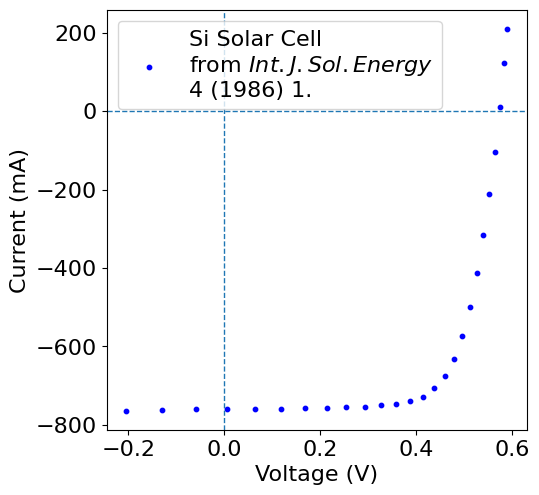

In [ ]:
######################################
plt.rcParams['font.size'] = 16
#
fig = plt.figure( figsize=(6,6) )
fig.subplots_adjust(left=0.22, right=0.92,
                    top=0.9, bottom=0.2)
#
ax1 = fig.add_subplot(1,1,1)
ax1.set_xlabel('Voltage (V)')
ax1.set_ylabel('Current (mA)')
#
ax1.scatter(X, Y*1e3, color='blue',
            s=10.0,
            label='Si Solar Cell \nfrom $Int. J. Sol. Energy$ \n4 (1986) 1.'
           )
#
(x_left, x_right) = ax1.set_xlim()
(y_bot, y_top) = ax1.set_ylim()
#
ax1.hlines(0, x_left, x_right,
           linestyles='dashed', linewidth=1.0)
ax1.vlines(0, y_bot, y_top,
           linestyles='dashed', linewidth=1.0)
#
#plt.title( r'Int. J. Sol. Ener. Cell' )
plt.legend()

In [ ]:
#
t0 = time.perf_counter()
#
with pm.Model() as model:
    Iph = pm.Uniform('Iph', lower=1e-2, upper=1e4 )  #mA
    Rp = pm.Uniform('Rp', lower=1e0, upper=1e5)      #Ohm
    Rs = pm.Uniform('Rs', lower=1e0, upper=1e8 )     #mOhm
    I0 = pm.Uniform('I0', lower=1e-1, upper=1e6 )    #nA
    n = pm.Uniform('n', lower=0.5, upper=500 )       #Vt(RT)=26 mV
#
    rmsd = pm.Uniform('rmsd', lower=0, upper=1e-2)
    mu = pm_I_Roberts_g(Iph, Rp, Rs, I0, n, X)
#
    y = pm.Normal('y', mu=mu, sigma=rmsd, observed=Y)
#
    trace_numpyro = pm.sampling_jax.sample_numpyro_nuts(10000, tune=10000, chains=2, target_accept=0.99)
#
t1 = time.perf_counter()
print( "elapsed time %.3f sec" % (t1-t0)  )

Compiling...


Compilation time =  0:00:42.371192
Sampling...


  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

Sampling time =  0:01:54.519311
Transforming variables...
Transformation time =  0:00:00.389502
elapsed time 160.099 sec


In [ ]:
def Roberts_g(x):
    if x <= -(np.exp(-1)):
        g = x
    elif x >= (np.exp(1)):
        g = np.log(x)
    else:
        g = -np.exp(1) + (1 + np.exp(1)) / (2 * np.exp(1)) * (x + np.exp(1))
#
    eg = np.exp(g)
    g = g - (2 * (g + eg - x) * (1 + eg)) / (2 * (1 + eg) ** 2 - (g + eg - x) * eg)
#
    eg = np.exp(g)
    g = g - (2 * (g + eg - x) * (1 + eg)) / (2 * (1 + eg) ** 2 - (g + eg - x) * eg)
#
    eg = np.exp(g)
    g = g - (2 * (g + eg - x) * (1 + eg)) / (2 * (1 + eg) ** 2 - (g + eg - x) * eg)
#
    eg = np.exp(g)
    g = g - (2 * (g + eg - x) * (1 + eg)) / (2 * (1 + eg) ** 2 - (g + eg - x) * eg)
#
    return g

In [ ]:
def I_Roberts_g(Iph, Rp, Rs, I0, n, V):
    Iph = Iph / 1000  #mA
    Rs = Rs / 1e3     #mOhm
    I0 = I0 / 1e9     #nA
    nVt = n*0.026     #Vt(RT)=26 mV
    LogQ = np.log(I0 * (Rs * Rp) / (Rs + Rp) / nVt) + (Rp / (Rs + Rp)) * (V + Rs * (I0 + Iph)) / nVt
    return (V - nVt * (Roberts_g(LogQ) - np.log(I0 * Rs * Rp / (Rs + Rp) / nVt))) / Rs

In [ ]:
def calcI(Iph, Rp, Rs, I0, n, V):
    V_list = V.tolist()
    I_list = [I_Roberts_g(Iph, Rp, Rs, I0, n, item) for item in V_list]
    return np.array(I_list)

In [ ]:
az.summary(trace_numpyro)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Iph,760.739,0.355,760.098,761.435,0.004,0.003,7599.0,9943.0,1.0
Rp,54.411,4.698,45.842,62.990,0.087,0.062,3085.0,3948.0,1.0
Rs,36.436,0.542,35.412,37.448,0.012,0.008,2200.0,2934.0,1.0
I0,321.459,38.393,255.687,397.183,0.866,0.622,2055.0,2787.0,1.0
n,1.502,0.012,1.479,1.524,0.000,0.000,2058.0,2776.0,1.0
rmsd,0.001,0.000,0.001,0.001,0.000,0.000,4757.0,5579.0,1.0


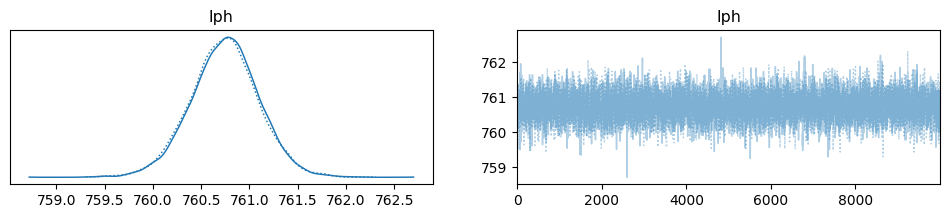

In [ ]:
with model:
  az.plot_trace(trace_numpyro, var_names=('Iph'))

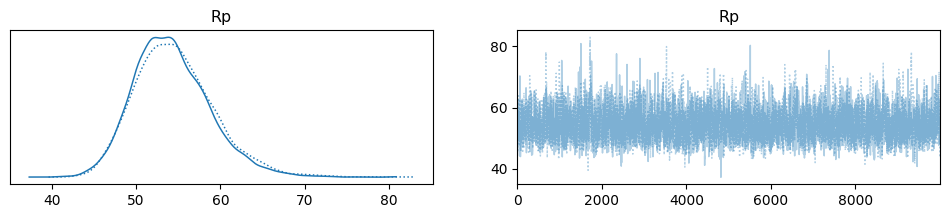

In [ ]:
with model:
  az.plot_trace(trace_numpyro, var_names=('Rp'))

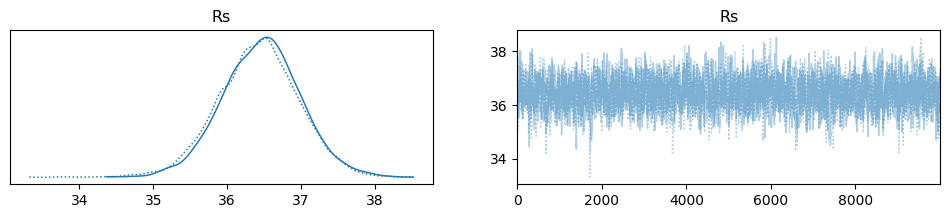

In [ ]:
with model:
  az.plot_trace(trace_numpyro, var_names=('Rs'))

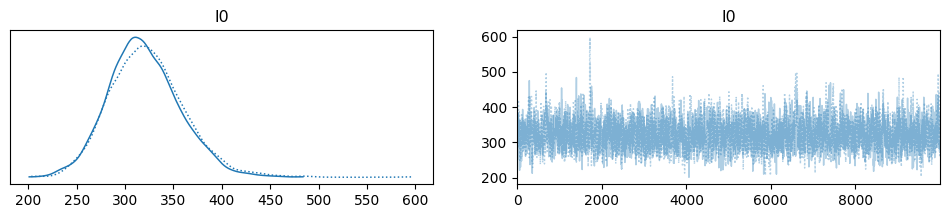

In [ ]:
with model:
  az.plot_trace(trace_numpyro, var_names=('I0'))

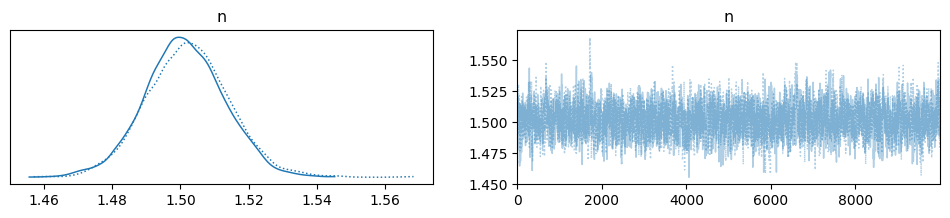

In [ ]:
with model:
  az.plot_trace(trace_numpyro, var_names=('n'))

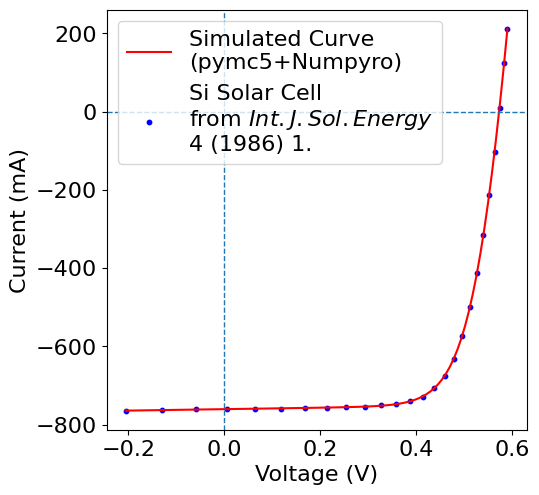

In [ ]:
######################################
plt.rcParams['font.size'] = 16
#
fig = plt.figure( figsize=(6,6) )
fig.subplots_adjust(left=0.22, right=0.92,
                    top=0.9, bottom=0.2)
#
ax1 = fig.add_subplot(1,1,1)
ax1.set_xlabel('Voltage (V)')
ax1.set_ylabel('Current (mA)')
#
ax1.scatter(X, Y*1e3, color='blue',
            s=10.0,
            label='Si Solar Cell \nfrom $Int. J. Sol. Energy$ \n4 (1986) 1.'
           )

xmin = np.amin(X)
xmax = np.amax(X)
N = 100
X_range = np.linspace(xmin, xmax, num=N, endpoint=True )

Q = az.summary(trace_numpyro)
Iph_m = Q.loc['Iph','mean']
Rp_m = Q.loc['Rp','mean']
Rs_m = Q.loc['Rs','mean']
I0_m = Q.loc['I0','mean']
n_m = Q.loc['n','mean']
I_list = calcI(Iph_m, Rp_m, Rs_m, I0_m, n_m, X_range)

ax1.plot(X_range, I_list*1e3, color='red',
            label='Simulated Curve\n(pymc5+Numpyro)'
           )

#
(x_left, x_right) = ax1.set_xlim()
(y_bot, y_top) = ax1.set_ylim()
#
ax1.hlines(0, x_left, x_right,
           linestyles='dashed', linewidth=1.0)
ax1.vlines(0, y_bot, y_top,
           linestyles='dashed', linewidth=1.0)
#
handles, labels = ax1.get_legend_handles_labels()
plt.legend(handles[::-1], labels[::-1])